In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shroomdk import ShroomDK
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PowerTransformer

In [ ]:
pip install shroomdk

In [5]:
#Setting up shroomDK powered by Flipside
my_address = '0x06ED7E490144D4b74BD1C9F33F69DA402603540E'
key = '74d495c5-4a92-4d2f-baf4-b0296d042dcb'
sdk = ShroomDK(key)

In [6]:
def create_sql_list(df,col):
    df_new = ""
    inputs = list(df[col])
    i = 0
    for row in inputs:
        if i < len(inputs) - 1:
            df_new = df_new + "lower('" + row + "'),"
        else:
            df_new = df_new + "lower('" + row + "')"
        i += 1
    df_new = df_new + ""
    return df_new   

In [12]:
import math
def find_airdropers():
    sql = f"""with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  
  in_transfers_all as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers,
  SUM(in_volume) as in_volume
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE symbol LIKE 'OP'
  and block_timestamp > bt) f GROUP BY 1),
  
  in_transfers_30 as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers_30,
  SUM(in_volume) as in_volume_30
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 30
  and block_timestamp > bt
  and symbol LIKE 'OP')  GROUP BY 1
  ),

  out_transfers_30 as (SELECT 
  from_address,
  COUNT(out_volume) as no_out_transfers_30,
  SUM(out_volume) as out_volume_30
  FROM (SELECT 
  from_address,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient =from_address
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 30
  and symbol LIKE 'OP') f GROUP BY 1
  ),

  in_transfers_7 as (SELECT 
  to_address,
  COUNT(in_volume) as no_in_transfers_7,
  SUM(in_volume) as in_volume_7
  FROM (SELECT 
  to_address,
  raw_amount / power(10, decimals) as in_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = TO_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 7
  and block_timestamp > bt
  and symbol LIKE 'OP')  GROUP BY 1
  ),

  out_transfers_7 as (SELECT 
  from_address,
  COUNT(out_volume) as no_out_transfers_7,
  SUM(out_volume) as out_volume_7
  FROM (SELECT 
  from_address,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient =from_address
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE datediff(day,bt, block_timestamp) < 7
  and symbol LIKE 'OP') f GROUP BY 1
  ),

  out_transfers_all as (SELECT
  FROM_ADDRESS,
  COUNT(*) as no_out_transfers,
  SUM(out_volume) as out_volume
  FROM (SELECT 
  FROM_ADDRESS,
  raw_amount / power(10, decimals) as out_volume 
  FROM optimism.core.fact_token_transfers
  INNER JOIN airdrop_recipients ON airdrop_recipient = FROM_ADDRESS
  LEFT outer JOIN optimism.core.dim_contracts
  ON address = contract_address
  WHERE symbol LIKE 'OP'
 ) GROUP BY from_address
  )
  
    SELECT
    airdrop_recipient,
    bt as time_airdrop_claimed,
    current_date - DATE(bt) as days_since_claim,
    amount,
    "Optimism Users",
    "Repeated Optimism Users",
    "DAO Voters",
    "Multisig Signers",
    "Gitcoin Donors (on L1)",
    "Users Priced Out of Ethereum",
     delegator,
     amount - COALESCE(out_volume,0) + COALESCE(in_volume,0) as curent_op_balance,
    ((amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) - amount) / amount as op_percent_change,
    ((amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) - amount) / amount as op_percent_change_7,
     CASE WHEN ((amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) < amount THEN 1 ELSE 0 END AS sold_some_op,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) > amount THEN 1 ELSE 0 END AS increased_op,
     CASE WHEN (amount - COALESCE(out_volume,0) + COALESCE(in_volume,0)) = amount THEN 1 ELSE 0 END AS hodl,
     CASE WHEN ((amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped_30,
     CASE WHEN (amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) < amount THEN 1 ELSE 0 END AS sold_some_op_30,
     CASE WHEN (amount - COALESCE(out_volume_30,0) + COALESCE(in_volume_30,0)) > amount THEN 1 ELSE 0 END AS increased_op_30,
     CASE WHEN ((amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) - amount) / amount < -.89 THEN 1 ELSE 0 END AS dumped_7,
     CASE WHEN (amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) < amount THEN 1 ELSE 0 END AS sold_some_op_7,
     CASE WHEN (amount - COALESCE(out_volume_7,0) + COALESCE(in_volume_7,0)) > amount THEN 1 ELSE 0 END AS increased_op_7
  FROM airdrop_recipients
  LEFT JOIN out_transfers_all oa on airdrop_recipient = oa.FROM_ADDRESS
  LEFT JOIN in_transfers_all ia on airdrop_recipient = ia.to_address
  LEFT JOIN out_transfers_30 ot on airdrop_recipient = ot.FROM_ADDRESS
  LEFT JOIN in_transfers_30  it on airdrop_recipient = it.to_address
  LEFT JOIN out_transfers_7 ott on airdrop_recipient = ott.FROM_ADDRESS
  LEFT JOIN in_transfers_7  itt on airdrop_recipient = itt.to_address
  """
    query_result_set = sdk.query(sql,page_number=1)
    query_result_set2 = sdk.query(sql,page_number=2)
    hoppers = pd.DataFrame(query_result_set.records)
    hoppers2 = pd.DataFrame(query_result_set2.records)
    hoppers = pd.concat([hoppers,hoppers2])
    return hoppers 

In [ ]:
%matplotlib inline

In [14]:
#Hop Airdrop Info
df_hop_airdrop = find_airdropers()
print(len(df_hop_airdrop))
print(len(df_hop_airdrop['airdrop_recipient'].unique()))

149250
149250


In [ ]:
plt.title('Number of Airdrop Wallets that increased position post OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["increased_op"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [ ]:
plt.title('Number of Airdrop Wallets that increased position post OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["hodl"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [ ]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [ ]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop within 30 Days')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped_30"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [ ]:
plt.title('Number of Airdrop Wallets that dumped OP airdrop within a week')
plt.ylabel('Number of Wallets')
ax = sns.countplot(x=df_hop_airdrop["dumped_7"])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

In [ ]:
xx = pd.DataFrame(df_hop_airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped'}).reset_index()
xx7 = pd.DataFrame(df_hop_airdrop.groupby('dumped_30')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_30'}).reset_index()
xx30 = pd.DataFrame(df_hop_airdrop.groupby('dumped_7')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_7'}).reset_index()
xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped_30')
xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped_7')
xx  = xx.drop(columns=['dumped','dumped_30','dumped_7'])
xx['Total_Wallets_Dumped'] = xx['Total_Wallets_Dumped'] / len(df_hop_airdrop)
xx['Total_Wallets_Dumped_30'] = xx['Total_Wallets_Dumped_30'] / len(df_hop_airdrop)
xx['Total_Wallets_Dumped_7'] = xx['Total_Wallets_Dumped_7'] / len(df_hop_airdrop)
xx

In [ ]:
df_hop_airdrop.columns

In [ ]:
yy = pd.DataFrame()
cols = ['optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    xx = pd.DataFrame(airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped'}).reset_index()
    xx7 = pd.DataFrame(airdrop.groupby('dumped_30')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_30'}).reset_index()
    xx30 = pd.DataFrame(airdrop.groupby('dumped_7')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Total_Wallets_Dumped_7'}).reset_index()
    xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped_30')
    xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped_7')
    xx  = xx.drop(columns=['dumped','dumped_30','dumped_7'])
    xx['Total_Wallets_Dumped'] = xx['Total_Wallets_Dumped'] / len(airdrop)
    xx['Total_Wallets_Dumped_30'] = xx['Total_Wallets_Dumped_30'] / len(airdrop)
    xx['Total_Wallets_Dumped_7'] = xx['Total_Wallets_Dumped_7'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]

In [ ]:
yy = pd.DataFrame()
cols = ['optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    xx = pd.DataFrame(airdrop.groupby('delegator')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Wallets_Delegate'}).reset_index()
    xx['Wallets_Delegate'] = xx['Wallets_Delegate'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]


In [ ]:
yy = pd.DataFrame()

cols = ['optimism users','repeated optimism users','dao voters','multisig signers','gitcoin donors (on l1)', 'users priced out of ethereum']
for col in cols:
    airdrop = df_hop_airdrop[df_hop_airdrop[col] == 1]
    airdrop = airdrop[airdrop['delegator'] == 1]
    xx = pd.DataFrame(airdrop.groupby('dumped')['airdrop_recipient'].count()).rename(columns={'airdrop_recipient':'Wallets_Delegate'}).reset_index()
    xx['Wallets_Delegate'] = xx['Wallets_Delegate'] / len(airdrop)
    xx['OP Airdrop Type'] = col
    yy = pd.concat([xx,yy])
yy = yy.reset_index()
yy[yy['index'] == 1]


In [ ]:
#Op Info
def get_op_info():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  op as (SELECT 
    block_timestamp,
    tx_hash,
    1 as tx_hash_to,
    0 as tx_hash_from,
    from_address as "user",
    to_address as interaction,
    to_address as  no_interactions_to,
    '' as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    WHERE block_timestamp < '2022-04-26'

    UNION ALL

    SELECT
    block_timestamp,
    tx_hash,
    0 as tx_hash_to,
    1 as tx_hash_from,
    to_address as "user",
    from_address as interaction,
    '' as  no_interactions_to,
    from_address as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    WHERE block_timestamp < '2022-04-26')


    SELECT  
    "user",
    COUNT(DISTINCT(tx_hash)) as total_txs,
    SUM(tx_hash_to) as total_txs_to,
    SUM(tx_hash_from) as total_txs_from,
    SUM(tx_hash_to) / COUNT(DISTINCT(tx_hash)) as perc_tx_to,
    COUNT(DISTINCT(DATE(block_timestamp))) as active_days,
    COUNT(DISTINCT(DATE_TRUNC('WEEK',block_timestamp))) as active_weeks,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as days_since_last_used,
    CURRENT_DATE - MIN(DATE(block_timestamp)) as days_since_first_used,
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span_op,
    COUNT(DISTINCT(interaction)) as distinct_interaction,
    COUNT(DISTINCT(no_interactions_to)) as no_interactions_to,
    COUNT(DISTINCT(no_interactions_from)) as no_interactions_from,
    COUNT(DISTINCT(no_interactions_to)) / COUNT(DISTINCT(no_interactions_from)) as to_from_ratio,
    COUNT(DISTINCT(tx_hash)) / COUNT(DISTINCT(DATE(block_timestamp))) as txs_per_day,
    SUM(tx_fee) as total_fees
    FROM op 
    GROUP BY "user"
   
    """
    query_result_set = sdk.query(sql,page_number = 1)
    query_result_set2 = sdk.query(sql,page_number = 2)
    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    
    return owner

# Adress Info

In [ ]:
def get_eth_address_info():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),

    
    addy as (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_from_address
    AND block_timestamp < '2022-04-26'

    UNION ALL

    SELECT 
    tx_hash,
    EVENT_NAME,
    origin_to_address as address,
    block_timestamp,
    origin_from_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_to_address
    AND block_timestamp < '2022-04-26'
    ),
    
    from_add as (
    SELECT 
    address,
      COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_from,
      COUNT(DISTINCT(f.interact)) as unique_addresses_interact_from,
      CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_from,
      CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_from
    FROM (SELECT
    tx_hash,
    from_address as address,
    block_timestamp,
    to_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    AND block_timestamp < '2022-04-26') f
     GROUP BY address),

    to_add as (
    SELECT 
    address,
  COUNT(DISTINCT(f.tx_hash)) as no_owner_tx_to,
  COUNT(DISTINCT(f.interact)) as unique_addresses_interact_to,
  CURRENT_DATE -  MIN(DATE(f.block_timestamp)) as days_since_first_tx_to,
  CURRENT_DATE -  MAX(DATE(f.block_timestamp)) as days_since_last_tx_to
    FROM (SELECT
    tx_hash,
    to_address as address,
    block_timestamp,
    from_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    AND block_timestamp < '2022-04-26') f
     GROUP BY address),

  op_bridge as (
    SELECT 
    address,
    COUNT(distinct(tx_hash)) as no_bridges,
    SUM(amount_bridged) as total_amount_bridge,
    COUNT(DISTINCT(block_timestamp)) as distinct_bridge_days,
    MAX(deposit_small_eth) as bridge_small_amount,
    MIN(deposit_small_eth) as bridge_small_amount_all
    FROM (SELECT
    origin_from_address as address,
    block_timestamp,
    tx_hash,
    t.amount as amount_bridged,
    CASE WHEN t.amount < .1 THEN 1 ELSE 0 END as deposit_small_eth
    FROM ethereum.core.ez_eth_transfers t
    INNER JOIN airdrop_recipients ON airdrop_recipient = origin_from_address
    AND block_timestamp < '2022-04-26'
    and eth_to_address = '0x99c9fc46f92e8a1c0dec1b1747d010903e884be1') f
    GROUP BY address),



    temp2 as (SELECT 
      a.address,
      CURRENT_DATE -  MIN(DATE(a.block_timestamp)) as days_since_first_tx,
      CURRENT_DATE -  MAX(DATE(a.block_timestamp)) as days_since_last_tx,
       MAX(DATE(a.block_timestamp)) - MIN(DATE(a.block_timestamp)) as activity_span,
      COUNT(DISTINCT(a.tx_hash)) as no_owner_tx,
      COUNT(DISTINCT(a.contract_address)) as no_contracts,
      COUNT(DISTINCT(a.EVENT_NAME)) as no_events,
      COUNT(DISTINCT(a.interact)) as unique_addresses_interact 
    FROM addy a
    GROUP BY a.address) 
    
    
    SELECT 
    a.address,
    days_since_first_tx,
    days_since_last_tx,
    activity_span,
    no_owner_tx,
    no_contracts,
    no_events,
    unique_addresses_interact,
    no_owner_tx_from,
    unique_addresses_interact_from,
    days_since_first_tx_from,
    days_since_last_tx_from,
    no_owner_tx_to,
    unique_addresses_interact_to,
    days_since_first_tx_to,
    days_since_last_tx_to,
    no_owner_tx_from / (no_owner_tx+1)  as percent_from_tx,
    unique_addresses_interact_from / (unique_addresses_interact+1) as unique_addresses_interact_from_percent,
    days_since_last_tx_from - days_since_last_tx_to as days_since_last_diff,
    no_bridges,
    total_amount_bridge,
    bridge_small_amount,
    distinct_bridge_days,
    bridge_small_amount_all
    FROM temp2 a
    LEFT JOIN to_add t ON  t.address = a.address
    LEFT JOIN from_add f ON f.address = a.address
    LEFT JOIN op_bridge o ON o.address = a.address
    """
    query_result_set = sdk.query(sql)
    query_result_set2 = sdk.query(sql, page_number =2)

    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    return owner

# Interaction Info

In [ ]:
def get_interactions():
    sql = f"""with temp as (SELECT 
    block_timestamp as bt,
    ORIGIN_FROM_ADDRESS as airdrop_recipient,
    raw_amount / power(10, decimals) as amount,
    case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
    case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
    case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
    case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
    case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
    case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
    CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
    contract_address as token
    FROM optimism.core.fact_token_transfers
    LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
    LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
    WHERE symbol LIKE 'OP'
    AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
    AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
    ),

    airdrop_recipients as (
    SELECT
    airdrop_recipient,
    token,
    MIN(bt) as bt,
    SUM(amount) as amount,
    MAX("Optimism Users") as "Optimism Users",
    MAX("Repeated Optimism Users") as "Repeated Optimism Users",
    MAX("DAO Voters") as "DAO Voters",
    MAX("Multisig Signers") as "Multisig Signers",
    MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
    MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
    MAX(delegator) as delegator
    FROM temp
    GROUP BY airdrop_recipient, token
    ),


    addy as (SELECT
    tx_hash,
    from_address as address,
    block_timestamp,
    to_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    AND block_timestamp < '2022-04-26'

    UNION ALL

    SELECT 
    tx_hash,
    to_address as address,
    block_timestamp,
    from_address as interact
    FROM ethereum.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    AND block_timestamp < '2022-04-26'
    ),

    interact_air as (SELECT  
    address,
    COUNT(DISTINCT(interact)) as no_other_airdrop_wallets_interacted_with,
    1 as interacted_with_other_airdrop_wallet
    FROM addy a
    INNER JOIN airdrop_recipients r ON airdrop_recipient = interact
    GROUP BY address),

    total_txs as (SELECT 
    *,
    row_number() OVER (PARTITION BY address ORDER BY block_timestamp) as row_number
    FROM addy
    ORDER BY block_timestamp),

    no_address_share_first_tx as (SELECT
    interact,
    COUNT(DISTINCT(address)) as no_address_share_first_tx,
    1 as shares_wallet_first_tx
    FROM total_txs
    WHERE row_number = 1  
    GROUP BY interact),

    left_em as (select
    address,
    no_address_share_first_tx,
    shares_wallet_first_tx
    FROM (SELECT address, interact FROM total_txs WHERE row_number =1) f
    INNER JOIN no_address_share_first_tx t ON f.interact = t.interact
    )

    SELECT 
    airdrop_recipient as address,
    no_address_share_first_tx,
    no_other_airdrop_wallets_interacted_with,
    CASE WHEN no_address_share_first_tx > 1 THEN 1 ELSE 0 END as shares_wallet_first_tx
    FROM airdrop_recipients
    LEFT JOIN left_em l ON airdrop_recipient = l.address
    LEFT JOIN interact_air i ON airdrop_recipient = i.address
    """
    query_result_set = sdk.query(sql)
    query_result_set2 = sdk.query(sql, page_number =2)

    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    return owner

In [ ]:
#Op Info
def get_op_info_post():
    sql = f""" with temp as (SELECT 
  block_timestamp as bt,
  ORIGIN_FROM_ADDRESS as airdrop_recipient,
  raw_amount / power(10, decimals) as amount,
  case when raw_amount/pow(10,18) between 776 and 777 then 1 else 0 END as "Optimism Users",
  case when raw_amount/pow(10,18) between 2469 and 2470 then 1 else 0 END as "Repeated Optimism Users",
  case when raw_amount/pow(10,18) between 271 and 272 then 1 else 0 END as "DAO Voters",
  case when raw_amount/pow(10,18) between 1190 and 1191 then 1 else 0 END as "Multisig Signers",
  case when raw_amount/pow(10,18) between 555 and 556 then 1 else 0 END as "Gitcoin Donors (on L1)",
  case when raw_amount/pow(10,18) between 409 and 410 then 1 else 0 END as "Users Priced Out of Ethereum",
  CASE WHEN delegator IS NULL THEN 0 ELSE 1 END AS delegator,
  contract_address as token
  FROM optimism.core.fact_token_transfers
  LEFT outer JOIN optimism.core.dim_contracts ON address = contract_address
  LEFT JOIN (SELECT delegator FROM optimism.core.fact_delegations) ON ORIGIN_FROM_ADDRESS = delegator
  WHERE symbol LIKE 'OP'
  AND from_address LIKE lower('0xFeDFAF1A10335448b7FA0268F56D2B44DBD357de')
  AND ORIGIN_FUNCTION_SIGNATURE LIKE '0x2e7ba6ef'
  ),
  
  airdrop_recipients as (
  SELECT
  airdrop_recipient,
  token,
  MIN(bt) as bt,
  SUM(amount) as amount,
  MAX("Optimism Users") as "Optimism Users",
  MAX("Repeated Optimism Users") as "Repeated Optimism Users",
  MAX("DAO Voters") as "DAO Voters",
  MAX("Multisig Signers") as "Multisig Signers",
  MAX("Gitcoin Donors (on L1)") as "Gitcoin Donors (on L1)",
  MAX("Users Priced Out of Ethereum") as "Users Priced Out of Ethereum",
  MAX(delegator) as delegator
  FROM temp
  GROUP BY airdrop_recipient, token
  ),
  op as (SELECT 
    block_timestamp,
    tx_hash,
    1 as tx_hash_to,
    0 as tx_hash_from,
    from_address as "user",
    to_address as interaction,
    to_address as  no_interactions_to,
    '' as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = from_address
    WHERE block_timestamp > '2022-04-26'

    UNION ALL

    SELECT
    block_timestamp,
    tx_hash,
    0 as tx_hash_to,
    1 as tx_hash_from,
    to_address as "user",
    from_address as interaction,
    '' as  no_interactions_to,
    from_address as no_interactions_from,
    tx_fee
    FROM optimism.core.fact_transactions
    INNER JOIN airdrop_recipients ON airdrop_recipient = to_address
    WHERE block_timestamp > '2022-04-26')


    SELECT  
    "user",
    COUNT(DISTINCT(tx_hash)) as total_txs,
    SUM(tx_hash_to) as total_txs_to,
    SUM(tx_hash_from) as total_txs_from,
    SUM(tx_hash_to) / COUNT(DISTINCT(tx_hash)) as perc_tx_to,
    COUNT(DISTINCT(DATE(block_timestamp))) as active_days,
    COUNT(DISTINCT(DATE_TRUNC('WEEK',block_timestamp))) as active_weeks,
    CURRENT_DATE - MAX(DATE(block_timestamp)) as days_since_last_used,
    CURRENT_DATE - MIN(DATE(block_timestamp)) as days_since_first_used,
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span_op,
    COUNT(DISTINCT(interaction)) as distinct_interaction,
    COUNT(DISTINCT(no_interactions_to)) as no_interactions_to,
    COUNT(DISTINCT(no_interactions_from)) as no_interactions_from,
    COUNT(DISTINCT(no_interactions_to)) / COUNT(DISTINCT(no_interactions_from)) as to_from_ratio,
    COUNT(DISTINCT(tx_hash)) / COUNT(DISTINCT(DATE(block_timestamp))) as txs_per_day,
    SUM(tx_fee) as total_fees
    FROM op 
    GROUP BY "user"
   
    """
    query_result_set = sdk.query(sql,page_number = 1)
    query_result_set2 = sdk.query(sql,page_number = 2)
    owner = pd.DataFrame(query_result_set.records)
    owner2 = pd.DataFrame(query_result_set2.records)
    owner = pd.concat([owner,owner2])
    
    return owner

In [ ]:
# max_number =round(len(df_hop_airdrop) / 1000)
i = 0
df_bridge = pd.DataFrame()
df_address = pd.DataFrame()
df_interact = pd.DataFrame()
df_bridge_post = pd.DataFrame()
# while i < max_number:
#     first= i*1000
#     second= 1000 + i*1000
#     if first % 10000 == 0:
#         print (f"{i / max_number } % Complete")
#     string =create_sql_list(df_hop_airdrop[first:second],'airdrop_recipient')
    #querying data and concentating
bridge = get_op_info()
address = get_eth_address_info()
interact = get_interactions()
bridge = get_op_info_post()
df_bridge = pd.concat([df_bridge, bridge])
df_address = pd.concat([df_address,address])
df_interact = pd.concat([df_interact,interact])
df_bridge_post = pd.concat([df_bridge_post, df_bridge])
i += 1

In [ ]:
df_interact

In [ ]:
len(df_address['address'].unique())

In [ ]:
sns.color_palette("Spectral", as_cmap=True)

In [ ]:
#Airdrop Info

token = ['ENS','1INCH','Ribbon',
         'AMP','X2Y2',
         'EULER','BEND','UNI','DYDX']

from_address = [#'0xA35dce3e0E6ceb67a30b8D7f4aEe721C949B5970',
                '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                #'0x5a5ecd062083733c9aa27cb4c5f113c42f730261',
                #'0x0000000000000000000000000000000000000000',
                '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',
                '0x7902e4bfb1eb9F4559d55417Aee1Dc6E4b8cC1Bf',
                '0xF497b83CfBd31E7Ba1Ab646F3B50aE0aF52d03A1',
                '0xe6949137b24ad50cce2cf6b124b3b874449a41fa',
                #'0xcAfE001067cDEF266AfB7Eb5A286dCFD277f3dE5',
                '0xd524e29e3baf5bb085403ca5665301e94387a7e2',
                '0x1b5d2904be3e4711a848be09b17dee89e6a5bc27',
                '0x090d4613473dee047c3f2706764f49e0821d256e',
                '0x639192d54431f8c816368d3fb4107bc168d0e871'
                
                
                ]
contract_address = [#'0xf4d2888d29d722226fafa5d9b24f9164c092421e',
                   '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                   #'0x3b484b82567a09e2588a13d54d032153f0c0aee0',
                   '0x111111111117dc0aa78b770fa6a738034120c302',
                   '0x6123b0049f904d730db3c36a31167d9d4121fa6b',
                    '0x77fba179c79de5b7653f68b5039af940ada60ce0',
                    '0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9',
                    #'0x090E53c44E8a9b6B1bcA800e881455b921AEC420',
                    '0xd9Fcd98c322942075A5C3860693e9f4f03AAE07b',
                    '0x0d02755a5700414b26ff040e1de35d337df56218',
                    '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
                    '0x92D6C1e31e14520e676a687F0a93788B716BEff5'
                   ]

df_airdrops = pd.DataFrame({
    'Token':token,
    'From Address':from_address,
    'Contract Address': contract_address
})



In [ ]:
#functions query airdropers that have dumped a particular token in less than a week of a holding (wallet balence = 0)
def find_airdroppers(token,address,contract,airdropper_df):
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as airdrop_recipient,
    contract_address as token
    FROM ethereum.core.fact_token_transfers
    WHERE contract_address = lower('{contract}')
    and from_address = lower('{address}')
    )

    SELECT --distinct(user_address)
    ROW_NUMBER() OVER (PARTITION BY user_address ORDER BY bt) as "Row",
    --DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
    user_address as airdrop_recipient,
    prev_bal as amount_dumped
    FROM ethereum.core.ez_balance_deltas
    INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
    WHERE current_bal = 0
    and DATEDIFF(day, bt, block_timestamp) < 30
    """
    

    query_result_set = sdk.query(sql)
    
    dumpers = pd.DataFrame(query_result_set.records)
    dumpers = dumpers[dumpers["row"] == 1]
    dumpers.columns = [str(col) + '_' + token if col != 'user_address' else col for col in dumpers.columns]

    no_dumpers = len(dumpers)
    print(f'Identifed {no_dumpers} that dumped {token} within a month')
    
    col_name = 'Dumped ' + token
    row_name = 'row_' + token
    dumpers[col_name] = 1
#     print(dumpers.head())
    ids = 'airdrop_recipient' + '_' + token
    airdropper_df = pd.merge(airdropper_df,dumpers,left_on='airdrop_recipient',right_on= ids,how='left')
    airdropper_df = airdropper_df.drop(columns=[ids,row_name])
    no_addresses = airdropper_df.loc[airdropper_df[col_name] == 1,'airdrop_recipient'].unique()
    airdropper_df = airdropper_df.fillna(0)
    
    airdropper_df['Number of Airdrops Dumped'] = airdropper_df['Number of Airdrops Dumped'] + airdropper_df[col_name]
    airdropper_df['Tokens Dumped'] = np.where(airdropper_df[col_name] == 1, airdropper_df['Tokens Dumped'] +", "+ col_name, airdropper_df['Tokens Dumped'])
    
    print(f'Identifed {len(no_addresses)} owner addresses that dumped {token}')
    return airdropper_df, no_dumpers,len(no_addresses)
    

In [ ]:
i = 0
dumped = []
add = []
past_dump = df_hop_airdrop[['airdrop_recipient']].copy()
past_dump['Number of Airdrops Dumped'] = 0
past_dump['Tokens Dumped'] = ''
while i < len(df_airdrops):
    token = df_airdrops.loc[i,'Token']
    address = df_airdrops.loc[i,'From Address']
    contract = df_airdrops.loc[i,'Contract Address']
    past_dump, no_dumpers,no_addresses = find_airdroppers(token,address,contract,past_dump)
    dumped.append(no_dumpers)
    add.append(no_addresses)
    i += 1

In [ ]:
df_airdrops['# of Dumpers'] = dumped
df_airdrops['# of Addresses'] = add

In [ ]:
plt.figure()
plt.title('# of Addresses that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Dumpers")
plt.figure()
plt.title('# of Hop Airdroppers that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Addresses")
plt.figure()
plt.title('Histogram of Number of Aridrops previously dumped')
sns.histplot(x='Number of Airdrops Dumped',data=past_dump)

# ITS MERGING TIME

In [ ]:
past_dump.to_csv('PastDump_Op.csv')
df_bridge.to_csv('Bridge_Op.csv')
df_address.to_csv('Address_Op.csv')
df_interact.to_csv('Interactions_Op.csv')
df_bridge_post.to_csv('Post Op.csv')
df_hop_airdrop.to_csv('Airdrop.csv')
past_dump

In [16]:
past_dump = pd.read_csv('PastDump_Op.csv')
df_bridge= pd.read_csv('Bridge_Op.csv')
df_address= pd.read_csv('Address_Op.csv')
df_interact = pd.read_csv('Interactions_Op.csv')
df_hop_airdrop = pd.read_csv('Airdrop.csv')
df_op = pd.read_csv('Post Op.csv')

In [17]:
df = df_hop_airdrop.copy()
df_bridge = df_bridge.drop_duplicates()
df = pd.merge(df, df_bridge,left_on='airdrop_recipient',right_on='user', how = 'left')
df = pd.merge(df, df_address,left_on='airdrop_recipient',right_on='address', how = 'left')
df = pd.merge(df, past_dump,on='airdrop_recipient',how = 'left')
df = pd.merge(df, df_interact,left_on='airdrop_recipient',right_on='address', how = 'left')

In [18]:
df_op.describe()

,Unnamed: 0,total_txs,total_txs_to,total_txs_from,perc_tx_to,active_days,active_weeks,days_since_last_used,days_since_first_used,activity_span_op,distinct_interaction,no_interactions_to,no_interactions_from,to_from_ratio,txs_per_day,total_fees
count,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,149244.000000,1.492440e+05
mean,41625.868685,46.894930,46.024812,0.878722,0.932945,6.322887,3.750114,81.758309,132.028336,50.270028,9.690654,9.643537,1.655410,6.339764,3.846159,9.455088e-03
std,27702.727018,1267.902212,1266.992228,3.075104,0.106352,11.716203,4.532311,51.356749,19.762302,57.160304,15.190757,15.041924,2.019292,9.537774,9.833311,3.288183e-01
min,0.000000,1.000000,1.000000,0.000000,0.011905,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.016000,1.000000,8.888000e-08
25%,18655.000000,4.000000,4.000000,0.000000,0.875000,1.000000,1.000000,24.000000,130.000000,0.000000,3.000000,3.000000,1.000000,2.000000,2.000000,1.157781e-03
50%,37310.500000,7.000000,6.000000,0.000000,1.000000,2.000000,2.000000,107.000000,130.000000,21.000000,5.000000,5.000000,1.000000,4.000000,3.000000,1.966068e-03
75%,62688.250000,16.000000,15.000000,1.000000,1.000000,6.000000,4.000000,130.000000,131.000000,111.000000,9.000000,9.000000,2.000000,6.000000,4.875000,3.918727e-03
max,99999.000000,148272.000000,148258.000000,322.000000,1.000000,167.000000,24.000000,131.000000,166.000000,166.000000,1509.000000,1509.000000,300.000000,754.500000,1882.952381,6.521374e+01


In [19]:
# for column in df.columns:
#     print(column)

df['Dumped Token'] = df['Number of Airdrops Dumped'].apply(lambda x: 1 if x > 0 else 0)
df['total_txs_from'] = df['total_txs_from'].fillna(0)
df['total_txs'] = df['total_txs'].fillna(0)
df['% OP'] = df['total_txs'] / (df['no_owner_tx'] + df['total_txs'])
df['Never used OP'] = df['% OP'].apply(lambda x: 1 if x == 0 else 0)
df['Did Not Transact on Op'] = df['total_txs_from'].apply(lambda x:1 if x < 1 else 0)
df['Multi'] = df.apply(lambda x: 1 if (x['optimism users'] == 0) & (x['repeated optimism users'] == 0) & (x['dao voters'] == 0) & (x['multisig signers'] == 0) & (x['gitcoin donors (on l1)'] == 0) & (x['users priced out of ethereum'] == 0) else 0, axis =1)
X = df.copy()

cols = ['airdrop_recipient', 'time_airdrop_claimed', 'amount','delegator',
       'curent_op_balance', 'op_percent_change', 'op_percent_change_7',
       'dumped', 'sold_some_op', 'increased_op', 'hodl', 'dumped_30',
       'sold_some_op_30', 'increased_op_30', 'dumped_7', 'sold_some_op_7',
       'increased_op_7', 'Unnamed: 0_x', 'user', 'Unnamed: 0_y',
       'address_x', 'days_since_first_tx',
       'Unnamed: 0_x', 'Unnamed: 0_y', 'address_y','Tokens Dumped','days_since_claim']

X = X.drop(columns = cols)

y = df[['op_percent_change',
'op_percent_change_7',
'dumped',
'sold_some_op',
'increased_op',
'hodl',
'dumped_30',
'sold_some_op_30',
'increased_op_30',
'dumped_7',
'sold_some_op_7',
'increased_op_7']]

In [20]:
X = X.fillna(0)

In [21]:
log_cols = ['no_owner_tx'
           ]
scale_cols = [x for x in X.columns if x not in log_cols]
scale_pipe = make_pipeline(MinMaxScaler())
log_pipe = make_pipeline(PowerTransformer())

transformer = ColumnTransformer(remainder='passthrough',
    transformers=[
        ("scale", scale_pipe, scale_cols),
        ("log_transform", log_pipe, log_cols),
    ]
)

X = X.reset_index(drop = True)
scaled = transformer.fit_transform(X)  

X = pd.DataFrame(scaled, index=X.index, columns=X.columns)


In [22]:
# distortions = []
# inertias = []
# mapping1 = {}
# mapping2 = {}

# K = range(1, 10)
  
# for k in K:
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
  
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                         'euclidean'), axis=1)) / X.shape[0])
#     inertias.append(kmeanModel.inertia_)
  
#     mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                    'euclidean'), axis=1)) / X.shape[0]
#     mapping2[k] = kmeanModel.inertia_

# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()

In [23]:
km = KMeans(n_clusters=4)
km.fit(X)
label = km.labels_
df['Cluster'] = label

In [24]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X)
res = pd.DataFrame(pca.transform(X))

In [25]:
pca1 = abs(pca.components_[0])
pca2 = abs(pca.components_[1])
k = 10
pca1_index = np.argpartition(pca1, len(pca1) - k)[-k:]
pca2_index = np.argpartition(pca2, len(pca2) - k)[-k:]

In [26]:
pca1_most_important = X.columns[pca1_index]
pca2_most_important = X.columns[pca2_index]
print("Most Important Features for X: " + str(pca1_most_important))
print("Most Important Features for Y: " + str(pca2_most_important))

Most Important Features for X: Index(['unique_addresses_interact_from', 'unique_addresses_interact_to',
       'activity_span', 'shares_wallet_first_tx',
       'users priced out of ethereum', 'Dumped Token', 'Never used OP',
       'Did Not Transact on Op', 'optimism users', 'Multi'],
      dtype='object')
Most Important Features for Y: Index(['Never used OP', 'Multi', 'Did Not Transact on Op', 'active_weeks',
       'Dumped Token', 'no_other_airdrop_wallets_interacted_with',
       'total_amount_bridge', 'days_since_last_used', 'activity_span_op',
       'distinct_bridge_days'],
      dtype='object')


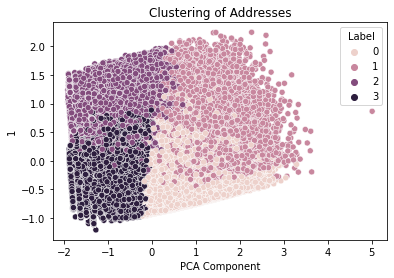

In [27]:
res['Label'] = label
plt.figure()
plt.title('Clustering of Addresses')
sns.scatterplot(x =0,y =1,hue ='Label',data = res)
plt.xlabel('PCA Component')
X['Label'] = label
df['Label'] = label

In [28]:
# df.groupby(['Within 30'])['airdrop_recipient'].count()
#df[['airdrop_recipient','days_since_first_tx_from']]
df[df['airdrop_recipient'] == '0x116048ed7c3ddc46ef87f7aa08a14079f6b50b1c']

,Unnamed: 0_x,airdrop_recipient,time_airdrop_claimed,days_since_claim,amount,optimism users,repeated optimism users,dao voters,multisig signers,gitcoin donors (on l1),...,no_address_share_first_tx,no_other_airdrop_wallets_interacted_with,shares_wallet_first_tx,Dumped Token,% OP,Never used OP,Did Not Transact on Op,Multi,Cluster,Label
1,1,0x116048ed7c3ddc46ef87f7aa08a14079f6b50b1c,2022-06-01 01:24:22.000,131,776.867362,1,0,0,0,0,...,NaN,NaN,0.0,0,NaN,0,0,0,3,3


In [29]:
print(df.groupby(['Label','dumped_30'])['airdrop_recipient'].count())

Label  dumped_30
0      0            13833
       1            34476
1      0             9141
       1            18881
2      0             7127
       1            16695
3      0            11999
       1            37098
Name: airdrop_recipient, dtype: int64


Supervised learning

In [30]:
from sklearn.model_selection import train_test_split
y2 = y['dumped']
X_train,X_test,y_train,y_test = train_test_split(X,y2,test_size = .3, random_state = 42)

In [31]:
df_address

,Unnamed: 0,address,days_since_first_tx,days_since_last_tx,activity_span,no_owner_tx,no_contracts,no_events,unique_addresses_interact,no_owner_tx_from,...,days_since_first_tx_to,days_since_last_tx_to,percent_from_tx,unique_addresses_interact_from_percent,days_since_last_diff,no_bridges,total_amount_bridge,bridge_small_amount,distinct_bridge_days,bridge_small_amount_all
0,0,0xa76cbd9b7d0e994266e8ca9f68df62f4e48c033c,258,167,91,2566,62,26,29,2734,...,258.0,171.0,1.065056,1.066667,-4.0,2.0,0.140000,1.0,2.0,1.0
1,1,0xbf6d406d6a33b2ecf00d2358746ac465bcd90651,574,167,407,1613,996,39,392,1891,...,574.0,175.0,1.171623,1.101781,-8.0,NaN,NaN,NaN,NaN,NaN
2,2,0xaf15b1b427089d5ed7c6d6304223b82cffe11076,801,170,631,382,209,69,113,431,...,801.0,180.0,1.125326,1.061404,-10.0,1.0,0.300000,0.0,1.0,0.0
3,3,0xc6893eeb690596e44f6c8668990a5cd7b8b1cedb,642,168,474,2893,527,123,314,3145,...,636.0,169.0,1.086731,1.104762,-2.0,1.0,0.025195,1.0,1.0,1.0
4,4,0x1d8775623df5469116ece78b55a97bce8424b899,585,168,417,319,240,77,144,378,...,585.0,168.0,1.181250,1.103448,0.0,2.0,0.140000,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136880,36880,0x50b165cc6087c802009a59390a6ba2a230f26803,348,168,180,2,4,3,2,6,...,351.0,168.0,2.000000,1.666667,0.0,1.0,0.057000,1.0,1.0,1.0
136881,36881,0x28a274aacc0795b49e51dbe646766b40f531daab,358,358,0,1,3,2,1,1,...,359.0,359.0,0.500000,0.500000,-1.0,1.0,0.079662,1.0,1.0,1.0
136882,36882,0x832346526d533011d10e65bf7520d9cbff0b0238,390,390,0,1,3,2,1,1,...,392.0,203.0,0.500000,0.500000,187.0,1.0,0.318000,0.0,1.0,0.0
136883,36883,0x8be8b54bf1891e9cf5c7524ee145fdf112ac5da5,365,365,0,1,3,2,1,1,...,NaN,NaN,0.500000,0.500000,NaN,1.0,0.004000,1.0,1.0,1.0


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection
from sklearn.svm import SVC
import xgboost as xgboost


lr = LogisticRegression()
rf = RandomForestClassifier()
# svc = SVC(random_state=0,probability=False)
xgb = xgboost.XGBClassifier()


# svc.fit(X_train, y_train)
# y_pred_svc = svc.predict(X_test)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

# calculate auc
# print(f"SVC AUC: {metrics.roc_auc_score(y_test, y_pred_svc)}")
print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf)}")
#print(f"LR AUC: {metrics.roc_auc_score(y_test, y_pred_lr)}")
print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_xgb)}")

C:\Users\jagorman\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jagorman\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RF AUC: 0.6731829399517165
XGB AUC: 0.6715540415639836


Oversampling

In [33]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# ros.fit(X_train,y_train)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# xgb_o = xgboost.XGBClassifier()
# xgb_o.fit(X_resampled, y_resampled)
# y_pred_o = xgb_o.predict(X_test)

# print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

In [34]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# rus.fit(X_train,y_train)
# X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
# xgb_o = xgboost.XGBClassifier()
# xgb_o.fit(X_resampled, y_resampled)
# y_pred_o = xgb_o.predict(X_test)

# print(f"XGB AUC: {metrics.roc_auc_score(y_test, y_pred_o)}")

In [35]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# ros.fit(X_train,y_train)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# rf = RandomForestClassifier()
# rf.fit(X_resampled, y_resampled)
# y_pred_rf_o = rf.predict(X_test)

# print(f"RF AUC: {metrics.roc_auc_score(y_test, y_pred_rf_o)}")

In [36]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
#elapsed_time = time.time() - start_time

#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

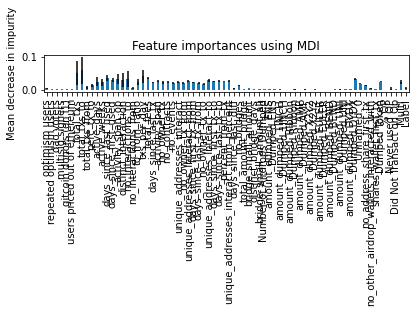

In [37]:
import pandas as pd
feature_names = [f"{i}" for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [38]:
X_test['y_test'] = y_test 
X_test['y_pred'] = y_pred_xgb 
df.iloc[X_test[X_test['y_test'] != X_test['y_pred']].index,:].to_csv('Why.csv')

<ipython-input-38-404147ba4214>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y_test'] = y_test
<ipython-input-38-404147ba4214>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y_pred'] = y_pred_xgb


In [39]:
df['Dumped DYDX'].unique()
df_hop_airdrop.iloc[101670,:].head(200)

Unnamed: 0                                                            1670
airdrop_recipient               0x6f1fd6ba42f11799913e6a91b6458ea9cd6887ca
time_airdrop_claimed                               2022-06-01 00:11:37.000
days_since_claim                                                       131
amount                                                         1048.701141
optimism users                                                           0
repeated optimism users                                                  0
dao voters                                                               0
multisig signers                                                         0
gitcoin donors (on l1)                                                   0
users priced out of ethereum                                             0
delegator                                                                1
curent_op_balance                                                 0.031141
op_percent_change        

In [40]:
forest_importances.sort_values(ascending=False).head(50)

total_txs_to                                0.058438
total_txs                                   0.049996
txs_per_day                                 0.040734
days_since_last_used                        0.035212
total_fees                                  0.034581
no_interactions_to                          0.033021
activity_span_op                            0.032839
Dumped DYDX                                 0.032353
days_since_first_used                       0.029916
distinct_interaction                        0.028591
unique_addresses_interact_to                0.028228
unique_addresses_interact_from              0.027121
days_since_last_tx_to                       0.026347
unique_addresses_interact_from_percent      0.025728
days_since_first_tx_to                      0.025200
activity_span                               0.025110
Dumped Token                                0.024650
percent_from_tx                             0.024327
active_days                                 0.

In [75]:
post = pd.merge(df_hop_airdrop,df_op,left_on='airdrop_recipient',right_on='user',how='left')
post = post.fillna(0)
post

,Unnamed: 0_x,airdrop_recipient,time_airdrop_claimed,days_since_claim,amount,optimism users,repeated optimism users,dao voters,multisig signers,gitcoin donors (on l1),...,active_weeks,days_since_last_used,days_since_first_used,activity_span_op,distinct_interaction,no_interactions_to,no_interactions_from,to_from_ratio,txs_per_day,total_fees
0,0,0xacb9684f762108dae82ff7fe202b08f135749c08,2022-05-31 22:53:37.000,132,681.260072,0,0,0,0,0,...,1.0,131.0,131.0,0.0,4.0,4.0,1.0,4.0,6.0,1.962185e-03
1,1,0x116048ed7c3ddc46ef87f7aa08a14079f6b50b1c,2022-06-01 01:24:22.000,131,776.867362,1,0,0,0,0,...,1.0,130.0,130.0,0.0,4.0,4.0,2.0,2.0,4.0,9.240539e-04
2,2,0x6fe9df41d7921ee62340bf7e27adcf6c4400bc3b,2022-05-31 20:27:19.000,132,271.833779,0,0,1,0,0,...,1.0,131.0,131.0,0.0,5.0,5.0,2.0,2.5,5.0,3.148938e-03
3,3,0xaf32d6cc6d10f63c069b272d31dcc6ced03901cc,2022-05-31 16:46:26.000,132,776.867362,1,0,0,0,0,...,1.0,131.0,131.0,0.0,4.0,4.0,1.0,4.0,5.0,2.473237e-03
4,4,0xc8473dd32b8a3e85fd68d1393cd6aa1720a88d4e,2022-07-12 11:16:09.000,90,776.867362,1,0,0,0,0,...,1.0,89.0,89.0,0.0,3.0,3.0,2.0,1.5,4.0,1.997360e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149245,49245,0xb0a1be32df8c8248a54389af5d5528c38d92d5be,2022-06-01 02:12:37.000,131,409.426293,0,0,0,0,0,...,1.0,130.0,130.0,0.0,3.0,3.0,1.0,3.0,6.0,1.860233e-03
149246,49246,0xf93c514f67f88163fa87dfd2e60d0ba0c096940d,2022-06-02 10:57:07.000,130,776.867362,1,0,0,0,0,...,2.0,123.0,129.0,6.0,2.0,2.0,1.0,2.0,1.0,8.314124e-04
149247,49247,0xbb179f078bac0ff4f181f6e01606ccae883ef74d,2022-06-01 11:34:12.000,131,681.260072,0,0,0,0,0,...,1.0,130.0,130.0,0.0,4.0,4.0,1.0,4.0,4.0,1.158908e-03
149248,49248,0x6efef34e81fd201edf18c7902948168e9ebb88ae,2022-06-07 14:02:51.000,125,409.426293,0,0,0,0,0,...,1.0,124.0,124.0,0.0,2.0,2.0,1.0,2.0,2.0,1.083045e-03


In [43]:
post.groupby('dumped')['active_weeks'].mean()
post.groupby('dumped')['activity_span_op'].mean()
post.columns

Index(['Unnamed: 0_x', 'airdrop_recipient', 'time_airdrop_claimed',
       'days_since_claim', 'amount', 'optimism users',
       'repeated optimism users', 'dao voters', 'multisig signers',
       'gitcoin donors (on l1)', 'users priced out of ethereum', 'delegator',
       'curent_op_balance', 'op_percent_change', 'op_percent_change_7',
       'dumped', 'sold_some_op', 'increased_op', 'hodl', 'dumped_30',
       'sold_some_op_30', 'increased_op_30', 'dumped_7', 'sold_some_op_7',
       'increased_op_7', 'Unnamed: 0_y', 'user', 'total_txs', 'total_txs_to',
       'total_txs_from', 'perc_tx_to', 'active_days', 'active_weeks',
       'days_since_last_used', 'days_since_first_used', 'activity_span_op',
       'distinct_interaction', 'no_interactions_to', 'no_interactions_from',
       'to_from_ratio', 'txs_per_day', 'total_fees'],
      dtype='object')

In [ ]:
plt.title('Active Weeks for Dumpers on Optimism')
sns.boxplot(data=post, x="dumped", y="active_weeks")

In [49]:
post_dump = post[post['dumped'] == 1]
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['active_weeks','active_days','activity_span_op','total_txs']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['active_weeks','active_days','activity_span_op','total_txs']].describe())

Stats for those to dump $OP
        active_weeks    active_days  activity_span_op      total_txs
count  116286.000000  116286.000000     116286.000000  116286.000000
mean        3.395774       5.623179         46.723552      48.396024
std         4.078083      10.691431         55.243365    1421.176445
min         0.000000       0.000000          0.000000       0.000000
25%         1.000000       1.000000          0.000000       5.000000
50%         2.000000       2.000000         14.000000       7.000000
75%         4.000000       5.000000        100.000000      14.000000
max        24.000000     167.000000        166.000000  148272.000000
Stats for those to keep $OP
       active_weeks   active_days  activity_span_op     total_txs
count  32964.000000  32964.000000      32964.000000  32964.000000
mean       4.999424      8.790074         62.771660     41.591039
std        5.686372     14.506828         61.860528    391.508655
min        0.000000      0.000000          0.000000      0.

In [76]:
post['Time Between Airdrop & Last Using OP'] = post['days_since_claim'] - post['days_since_last_used']

In [77]:
sns.boxplot(x='dumped',y='Time Between Airdrop & Last Using OP',data=post
print()

SyntaxError: invalid syntax (<ipython-input-77-0794a059c8a8>, line 2)

In [ ]:
post_dump = post[post['dumped'] == 1]
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['Time Between Airdrop & Last Using OP']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['Time Between Airdrop & Last Using OP']].describe())

In [101]:
post_d = post[post['dumped'] == 0]
post_d[['time_airdrop_claimed','days_since_claim','days_since_last_used','Time Between Airdrop & Last Using OP']].sort_values('days_since_last_used')

,time_airdrop_claimed,days_since_claim,days_since_last_used,Time Between Airdrop & Last Using OP
87250,2022-06-01 07:12:37.000,131,0.0,131.0
97792,2022-05-31 18:08:00.000,132,0.0,132.0
97771,2022-06-02 07:35:26.000,130,0.0,130.0
97762,2022-06-01 01:47:22.000,131,0.0,131.0
144978,2022-06-08 02:54:14.000,124,0.0,124.0
...,...,...,...,...
43988,2022-05-31 22:06:07.000,132,131.0,1.0
44058,2022-05-31 18:53:00.000,132,131.0,1.0
62354,2022-05-31 23:33:52.000,132,131.0,1.0
132541,2022-05-31 23:08:07.000,132,131.0,1.0


In [108]:
post['Didnt use OP - 3 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 3 else 0)
post['Didnt use OP - 7 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 7 else 0)
post['Didnt use OP - 30 Days'] = post['Time Between Airdrop & Last Using OP'].apply(lambda x:1 if x < 30 else 0)
post['Used in Past 14 Days'] = post['days_since_last_used'].apply(lambda x:1 if x < 14 else 0)

xx = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 3 Days'].sum()).rename(columns={'airdrop_recipient':'Didnt use OP - 3 Day'}).reset_index()
xx7 = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 7 Days'].sum()).rename(columns={'airdrop_recipient':'Didnt use OP - 7 Day'}).reset_index()
xx30 = pd.DataFrame(post.groupby('dumped')['Didnt use OP - 30 Days'].sum()).rename(columns={'airdrop_recipient':'Used OP for over a Mont'}).reset_index()
xx14 = pd.DataFrame(post.groupby('dumped')['Used in Past 14 Days'].sum()).rename(columns={'airdrop_recipient':'Used in Past 14 Days'}).reset_index()
xx = pd.merge(xx,xx7,left_on='dumped',right_on='dumped')
xx= pd.merge(xx,xx30,left_on='dumped',right_on='dumped')
xx= pd.merge(xx,xx14,left_on='dumped',right_on='dumped')
# xx  = xx.drop(columns=['Use OP - 30 Days','Didnt use OP - 3 Days','Didnt use OP - 7 Days'])
xx['Didnt use OP - 3 Days'] =  (xx['Didnt use OP - 3 Days'] / len(post))
xx['Didnt use OP - 7 Days'] =  (xx['Didnt use OP - 7 Days'] / len(post))
xx['Didnt use OP - 30 Days'] =   (xx['Didnt use OP - 30 Days'] / len(post))
xx['Used in Past 14 Days'] = xx['Used in Past 14 Days'] / len(post)
# xx  = xx.drop(columns=['Didnt use OP - 3 Day','Didnt use OP - 7 Day','Used OP for over a Mont'])
xx

,dumped,Didnt use OP - 3 Days,Didnt use OP - 7 Days,Didnt use OP - 30 Days,Used in Past 14 Days
0,0,0.090057,0.094372,0.107652,0.056402
1,1,0.344060,0.379464,0.463464,0.115719


In [ ]:
print('Stats for those to dump $OP')
print(post[post['dumped'] == 1][['Time Between Airdrop & Last Using OP']].describe())
print('Stats for those to keep $OP')
print(post[post['dumped'] == 0][['Time Between Airdrop & Last Using OP']].describe())

In [ ]:
import shap

explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test)

# # Make plot. Index of [1] is explained in text below.
# shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values, plot_type='violin')

In [78]:
# for i in df_hop_airdrop.columns:
#     try:
#         plt.figure()
#         plt.title(f'Historgram by Cluster - {i}')
#         sns.histplot(x=i,data=df_hop_airdrop)
#     except: 
#         a= 1

<AxesSubplot:title={'center':'Did a Address that Dumped a previous airdrop Dump $Hop?'}, xlabel='Number of Airdrops Dumped', ylabel='Count'>

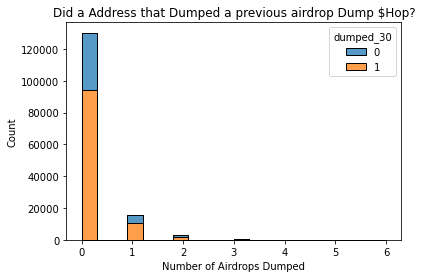

In [79]:
plt.figure()
plt.title('Did a Address that Dumped a previous airdrop Dump $OP?')
sns.histplot(x = 'Number of Airdrops Dumped',data =df,hue = 'dumped_30',element='step',multiple='stack',bins =20)

In [80]:
df.groupby(['Number of Airdrops Dumped','Within 30'])['airdrop_recipient'].count()

KeyError: 'Within 30'

In [ ]:
df[df['address'] == '0x042a135bd342910ad7f67bbda74e3fd4125d1272']